In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Load cleaned data
telco_churn_df = pd.read_csv('cleaned_telco_churn.csv')

# Define which columns should be encoded vs scaled
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create the transformer for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Create the transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data
X = telco_churn_df.drop('Churn', axis=1)
y = telco_churn_df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)  # Convert target to binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Create Benchmark model with LogRegression

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Create a modeling pipeline
model = make_pipeline(preprocessor, LogisticRegression(random_state=42))

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score, roc_auc_score
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"AUC ROC: {roc_auc_score(y_test, y_proba)}")


Accuracy: 0.8218594748048261
AUC ROC: 0.8622654155495979


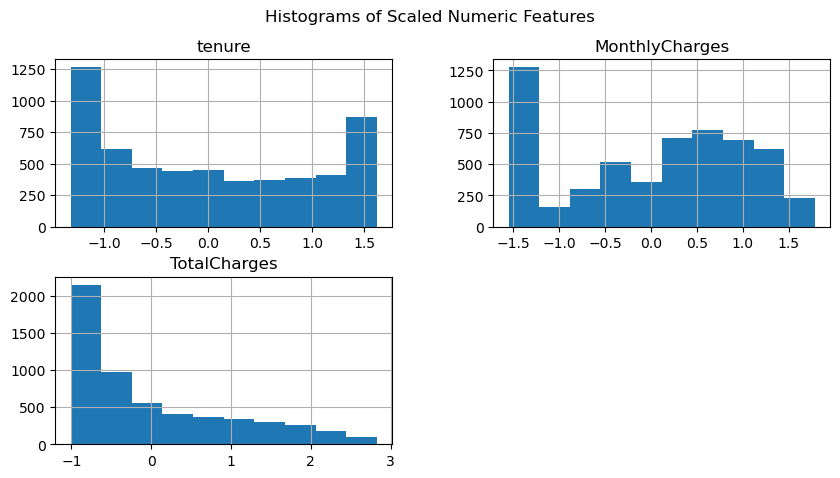

In [3]:
# Check scaled feature distribution again

import matplotlib.pyplot as plt

# Apply the numeric transformer to the numeric features
scaled_features = preprocessor.named_transformers_['num'].transform(X_train[numeric_features])

# Convert scaled features to DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=numeric_features)

# Plot histograms of scaled features
scaled_features_df.hist(figsize=(10, 5))
plt.suptitle('Histograms of Scaled Numeric Features')
plt.show()


In [4]:
# recheck one-hot encoding

# Access the transformed categorical data (assuming it's transformed separately for visualization)
encoded_features = preprocessor.named_transformers_['cat'].transform(X_train[categorical_features]).toarray()
encoded_features_df = pd.DataFrame(encoded_features)

# Check the shape and head of the encoded DataFrame
print(encoded_features_df.shape)
encoded_features_df.head()


(5634, 43)


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


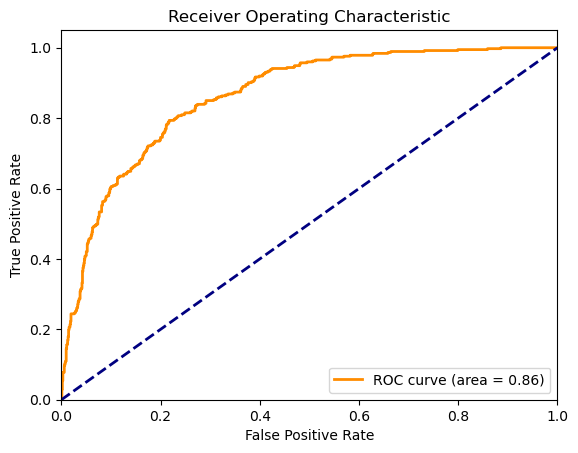

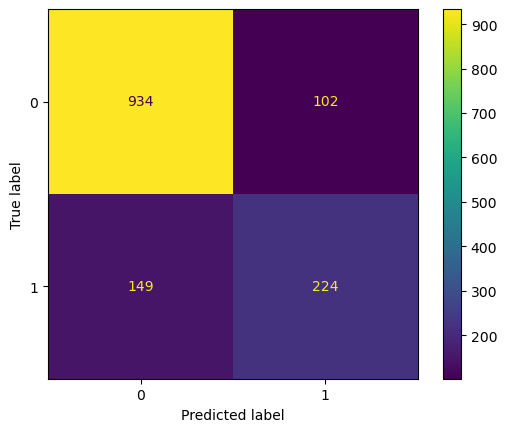

In [5]:
# Model performance visualization


from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


## Logistic Regression Conclusions

Accuracy of 82% is a solid starting point.

AUC ROC (0.862) is strong as well. More advanced ML models could produce even better results.

## Try Random Forest Classifier Next

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

#Initial Run

model_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
model_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("AUC ROC:", roc_auc_score(y_test, y_proba_rf))


Accuracy: 0.7920511000709723
AUC ROC: 0.8364080760193361


In [7]:
#Initial Run performed worse than the Logistic Regression. Try RandomSearch

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(model_rf, param_distributions, n_iter=10, cv=5, scoring='roc_auc', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score: {:.2f}".format(random_search.best_score_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}
Best score: 0.84


In [8]:
# retrain the model using best fit from randomsearch

# Re-create the pipeline with the best parameters
optimized_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=400,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42))
])

# Fit the pipeline to the training data
optimized_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=400,
                                        random_state=42))])

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Predictions
y_pred_optimized = optimized_pipeline.predict(X_test)
y_proba_optimized = optimized_pipeline.predict_proba(X_test)[:, 1]

# Evaluation metrics
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
optimized_auc_roc = roc_auc_score(y_test, y_proba_optimized)

print("Optimized Model Accuracy:", optimized_accuracy)
print("Optimized Model AUC ROC:", optimized_auc_roc)


Optimized Model Accuracy: 0.8112136266855926
Optimized Model AUC ROC: 0.8615550632976907


In [10]:
# Better than the intial RF run, but still worse than Logistic Regression outcome.

In [11]:
# Try GBM since it's known to be effective for classification problem like this

from sklearn.ensemble import GradientBoostingClassifier

# Setup the pipeline
model_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

# Train the model
model_gbm.fit(X_train, y_train)

# Predict and evaluate
y_pred_gbm = model_gbm.predict(X_test)
y_proba_gbm = model_gbm.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred_gbm))
print("AUC ROC:", roc_auc_score(y_test, y_proba_gbm))





Accuracy: 0.8097941802696949
AUC ROC: 0.8596698479406254


In [12]:
# Try random search for GBM

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

# Parameter distributions
param_dist = {
    'classifier__n_estimators': sp_randint(100, 400),  # Number of boosting stages to perform
    'classifier__learning_rate': uniform(0.01, 0.2),   # Learning rate
    'classifier__max_depth': sp_randint(3, 10),        # Maximum depth of the individual regression estimators
    'classifier__min_samples_split': sp_randint(2, 11),# The minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': sp_randint(1, 11)  # The minimum number of samples required to be at a leaf node
}


In [13]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [14]:
# Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=10,   
    cv=5,          
    scoring='roc_auc',  
    verbose=1, 
    random_state=42,
    n_jobs=-1      # Use all available cores
)

# Fit Randomized Search
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best score: {:.2f}".format(random_search.best_score_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'classifier__learning_rate': 0.09638900372842316, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 154}
Best score: 0.84


In [15]:
# Retrain GBM using the best fit

optimized_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        learning_rate=0.09638900372842316,
        max_depth=3,
        min_samples_leaf=10,
        min_samples_split=4,
        n_estimators=154,
        random_state=42))
])

# Fit the pipeline to the training data
optimized_gbm.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.09638900372842316,
                                            min_samples_leaf=10,
                                            min_samples_split=4,
                                            n_estimators=154,
                                            random_state=42))])

In [16]:
# Make predictions on the test data
y_pred_optimized = optimized_gbm.predict(X_test)
y_proba_optimized = optimized_gbm.predict_proba(X_test)[:, 1]

# Calculate accuracy and AUC ROC for the test data
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
optimized_auc_roc = roc_auc_score(y_test, y_proba_optimized)

print("Optimized GBM Model Accuracy:", optimized_accuracy)
print("Optimized GBM Model AUC ROC:", optimized_auc_roc)

Optimized GBM Model Accuracy: 0.8097941802696949
Optimized GBM Model AUC ROC: 0.8595546906538863


## Analysis and Potential Next Steps


Even after Random Search parameter tuning, the RF and GBM results only got close to Logistic Regression results, but couldn't surpass it. Due to my compute power limitation, I could only try 10 searches in random search.

Next Steps could be to try more intensive Grid Search with higher power compute resources.

In [20]:
#Plotting feature importance and key feature relationship to the target

#since LogRegression is the current winning model, we will analyze coefficients.

# Extract the logistic regression model from the pipeline
logistic_regression_model = model.named_steps['logisticregression']

# Get the coefficients
coefficients = logistic_regression_model.coef_[0]  # [0] because it returns an array in an array



In [21]:
# Map coefficients to the feature names
feature_names = preprocessor.get_feature_names_out()


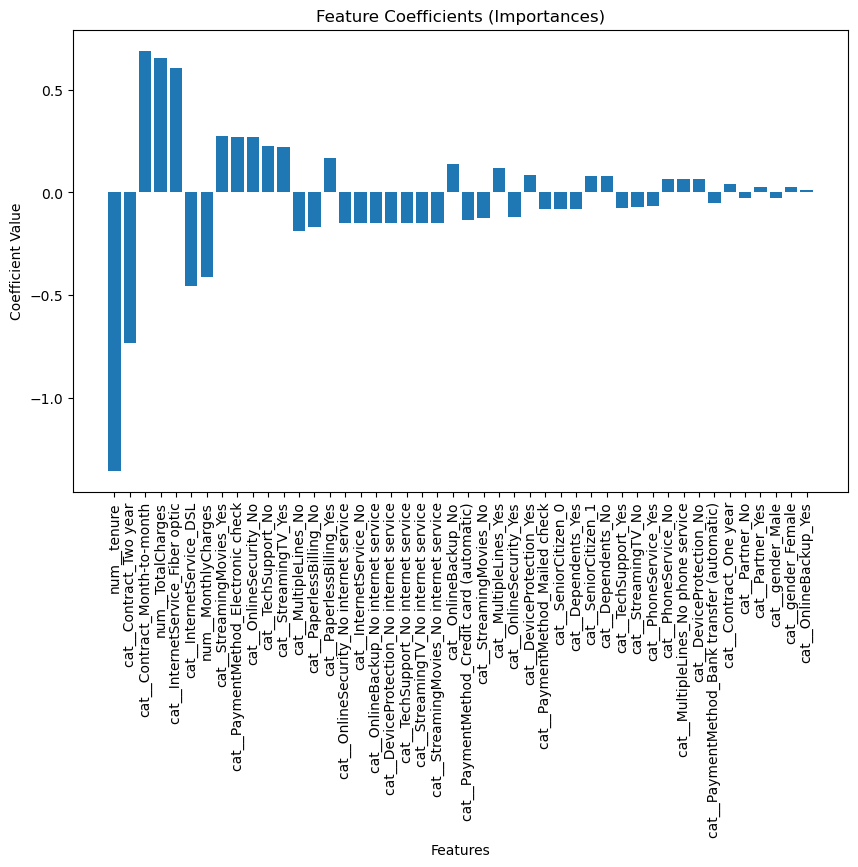

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Combine names and coefficients
features_coefficients = zip(feature_names, coefficients)

# Sort by the absolute values of coefficients
sorted_features_coefficients = sorted(features_coefficients, key=lambda x: abs(x[1]), reverse=True)

# Unpack the sorted pairs
sorted_features, sorted_coefficients = zip(*sorted_features_coefficients)

# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Coefficients (Importances)")
plt.bar(range(len(sorted_coefficients)), sorted_coefficients, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()


Conclusion:

Long customer tenure and 2 year contracts show strong negative correlation to churn, while month-to-month is strongly correlated to churn.
Also customers with DSL and FiberOptic internet services are highly correlated to churn while movie streaming is negatively correlated.

Potential Recommendations:

Push Multi-year and Renewal Promotions: This Telco should consider all means it has to encourage long-term commitment from the customer, and move customers away from month-to-month plans as much as possible.
Internet Service Products: This firm also should reevaluate its competitiveness as an ISP, as customers using its internet service are churning more.
Movie Streaming: This service seems to keep customers to this Telco. Consider promoting this service more strongly.